In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from sklearn import linear_model, covariance

/Users/mycomputer/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class Index:
  def __init__(self, ticker, start, end=None):
    self.start = start
    self.end = end
    self.ticker = ticker
    self.data = self.download_data()
    self.mean_return, self.volatility = self.calc_info()
  
  def download_data(self):
    yf_data = yf.download(self.ticker, start = self.start, end = self.end, auto_adjust=True)  # also pass period='1mo' as parameters if monthly
    yf_data.dropna(how='all', inplace=True)
    data = yf_data[['Close']].copy()
    data['Return'] = data['Close'].pct_change()
    return data
  
  def calc_info(self):
    mean_return = np.mean(self.data['Return'])
    volatility = np.std(self.data['Return'])
    return mean_return, volatility
  
  def __str__(self):
    return f'Benchmark Reference: {self.ticker}\n \t Mean rate of return: {self.mean_return}\n \t Volatility: {self.volatility}'

In [3]:
class Fama_French:
  def __init__(self, start, end=None):
    self.start = start
    self.end = end
    self.ticker = 'Fama-French'
    self.data = self.download_data()
    self.risk_free_rate, self.volatility = self.calc_info()
  
  def download_data(self):
    """Use monthly Fama-French 5 Factor if monthly
    ff_data = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip', compression='zip', skiprows=[0,1,2]).dropna()
    """
    ff_data = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip', compression='zip', skiprows=[0,1,2]).dropna()
    ff_data.columns = ['DATE', 'MKTRF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    ff_data['RF'] = ff_data['RF'] / 100
    ff_data['DATE'] = pd.to_datetime(ff_data['DATE'], format='%Y%m%d')  # use format='%Y%m' instead if monthly
    ff_data = ff_data[(ff_data['DATE'] >= self.start)]
    if self.end is not None:
      ff_data = ff_data[(ff_data['DATE'] <= self.end)]
    return ff_data
  
  def calc_info(self):
    risk_free_rate = np.mean(self.data['RF'])
    volatility = 0
    return risk_free_rate, volatility
  
  def __str__(self):
    return f'Benchmark Reference: {self.ticker}\n \t Risk-free rate: {self.risk_free_rate}\n \t Volatility: {self.volatility}'

In [4]:
class Portfolio:
  def __init__(self, tickers, start, end=None):
    self.tickers = [ticker.upper() for ticker in tickers]
    self.tickers.sort()
    self.start = start
    self.end = end
    self.data = self.download_data()
    self.mean_returns, self.predicted_returns, self.cov_matrix = self.calc_info()
  
  def download_data(self):
    yf_data = yf.download(self.tickers, start = self.start, end = self.end, auto_adjust=True)  # also pass period='1mo' as parameters if monthly
    yf_data = yf_data[(yf_data.index >= self.start)]
    if self.end is not None:
      yf_data = yf_data[(yf_data.index <= self.end)]
    yf_data = yf_data[['Close']]
    yf_data.dropna(how='all', inplace=True)
    
    returns = yf_data[['Close']].pct_change()
    returns.columns = returns.columns.set_levels(['Return'], level=0)
    data = pd.concat([yf_data, returns], axis=1)
    return data
  
  def calc_info(self):
    # Calculate average return of each stock
    mean_returns = [np.mean(self.data['Return'][ticker]) for ticker in self.tickers]
    
    # Calculate predicted return of each stock by applying the Fama-French 5 Factor Model
    returns = self.data['Return'].reset_index().melt(id_vars=["Date"], var_name="ASSET", value_name="RET").dropna()
    returns.columns = ['DATE', 'ASSET', 'RET']
    
    """Use monthly Fama-French 5 Factor if monthly
    ff5 = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip', compression='zip', skiprows=[0,1,2]).dropna()
    """
    ff5 = pd.read_csv('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip', compression='zip', skiprows=[0,1,2]).dropna()
    ff5.columns = ['DATE', 'MKTRF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    ff5['RF'] = ff5['RF'] / 100
    ff5['DATE'] = pd.to_datetime(ff5['DATE'], format='%Y%m%d')  # use format='%Y%m' if montly
    
    merged = pd.merge(returns, ff5, on="DATE")
    merged["XRET"] = merged["RET"] - merged["RF"]
    betas = {'ASSET':[], 'ff5_alpha':[], 'mkt_beta':[], 'smb_beta':[], 'hml_beta':[], 'rmw_beta':[], 'cma_beta':[]}
    
    for asset, group in merged.groupby(["ASSET"]):
        ff5model = linear_model.LinearRegression().fit(group[["MKTRF", "SMB", "HML", 'RMW', 'CMA']], group["XRET"])
        betas['ASSET'].append(asset)
        betas['ff5_alpha'].append(ff5model.intercept_)
        betas['mkt_beta'].append(ff5model.coef_[0])
        betas['smb_beta'].append(ff5model.coef_[1])
        betas['hml_beta'].append(ff5model.coef_[2])
        betas['rmw_beta'].append(ff5model.coef_[3])
        betas['cma_beta'].append(ff5model.coef_[4])
    
    betas = pd.DataFrame(betas)
    """Adjust the beta
    betas['ff5_beta'] = [(beta * 2/3 + 1/3) for beta in betas['ff5_beta']]
    """
    # betas['ff5_beta'] = [(beta * 2/3 + 1/3) for beta in betas['ff5_beta']]
    betas['PREDICT_RET'] = betas['ff5_alpha'] + betas['mkt_beta']*np.mean(merged['MKTRF']) + betas['smb_beta']*np.mean(merged['SMB']) + betas['hml_beta']*np.mean(merged['HML']) + betas['rmw_beta']*np.mean(merged['RMW']) + betas['cma_beta']*np.mean(merged['CMA'])
    predicted_returns = betas['PREDICT_RET'].to_list()
  
    # Calculate covariance matrix using OAS shrinkage
    """Choose the period accordingly
    returns = self.data['Return'].resample('1W').mean().apply(lambda x: (x + 1)**7 - 1).fillna(0)
    returns = self.data['Return'].resample('1M').mean().apply(lambda x: (x + 1)**30 - 1).fillna(0)
    """
    returns = self.data['Return'][1:].fillna(0)
    cov_matrix = covariance.oas(returns)[0]
    return mean_returns, predicted_returns, cov_matrix
  
  def __str__(self) -> str:
    return f'Portfolio Basic Information:\n \t Portfolio Assets: {self.tickers}\n \t Average Returns: {self.mean_returns}\n \t Predicted Returns: {self.predicted_returns}'

In [5]:
class MVO:
  def __init__(self, portfolio, fama_french, bounds=None):
    self.portfolio = portfolio
    self.fama_french = fama_french
    self.bounds = bounds
    self.strategies = {
      'minimum_volatility': {},
      'maximum_return': {},
      'maximum_sharpe': {},
      'maximum_utility': {}
    }
  
  def portfolio_volatility(self, weights):
    variance = np.dot(weights.T, np.dot(self.portfolio.cov_matrix, weights))
    return np.sqrt(variance)
  
  def portfolio_return(self, weights):
    return np.dot(weights.T, self.portfolio.predicted_returns)
  
  def portfolio_return_negate(self, weights):
    return -1 * self.portfolio_return(weights)
  
  def portfolio_sharpe_negate(self, weights, risk_free_rate):
    return -(self.portfolio_return(weights) - risk_free_rate) / self.portfolio_volatility(weights)
  
  def portfolio_utility_negate(self, weights, risk_aversion):
    return -(self.portfolio_return(weights) - (1 / 2) * risk_aversion * self.portfolio_volatility(weights))
  
  def minimum_volatility(self, expected_return=None):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)
    
    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    if expected_return is not None:
      constraints.append({"type": "eq", "fun": lambda x: self.portfolio_return(x) - expected_return})
    
    result = minimize(fun=self.portfolio_volatility,
                      x0=init_guess,
                      args=(),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)
    
    self.strategies['minimum_volatility'] = {
      "Weights": result.x,
      "Return": self.portfolio_return(result.x),
      "Volatility": result.fun
    }
  
  def maximum_return(self, expected_volatility=None):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)
    
    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    if expected_volatility is not None:
      constraints.append({"type": "eq", "fun": lambda x: self.portfolio_volatility(x) - expected_volatility})
    
    result = minimize(fun=self.portfolio_return_negate,
                      x0=init_guess,
                      args=(),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)
    
    self.strategies['maximum_return'] = {
      "Weights": result.x,
      "Return": -result.fun,
      "Volatility": self.portfolio_volatility(result.x)
    }
  
  def maximum_sharpe(self):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)
    
    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    
    result = minimize(fun=self.portfolio_sharpe_negate,
                      x0=init_guess,
                      args=(self.fama_french.risk_free_rate),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)
    
    self.strategies['maximum_sharpe'] = {
      "Weights": result.x,
      "Return": self.portfolio_return(result.x),
      "Volatility": self.portfolio_volatility(result.x),
      "Sharpe Ratio": -result.fun
    }
  
  def maximum_utility(self, risk_aversion=5):
    init_guess = np.ones(len(self.portfolio.tickers)) / len(self.portfolio.tickers)    
    
    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    
    result = minimize(fun=self.portfolio_utility_negate,
                      x0=init_guess,
                      args=(risk_aversion),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=self.bounds)
    
    self.strategies['maximum_utility'] = {
      "Weights": result.x,
      "Return": self.portfolio_return(result.x),
      "Volatility": self.portfolio_volatility(result.x),
      "Utility": -result.fun
    }
  
  def plot_MVO(self):
    r_low = min(self.portfolio.predicted_returns)
    r_high = max(self.portfolio.predicted_returns)
    returns = np.linspace(r_low, r_high, 51)
    vol = []
    
    for ret in returns:
      self.minimum_volatility(ret)
      vol.append(self.strategies['minimum_volatility']["Volatility"])
    self.minimum_volatility()
    
    plt.plot(vol, returns)
    plt.title('Minimum-Variance Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.scatter(self.strategies['minimum_volatility']['Volatility'], self.strategies['minimum_volatility']['Return'], s=40, c='green')
    plt.text(self.strategies['minimum_volatility']['Volatility']+0.001, self.strategies['minimum_volatility']['Return']-0.0001, f'GMVP', color='green')
    plt.show()

In [6]:
def plotReturns(portfolio, index, weights):
  index_trace = [1000]
  for ret in index.data["Return"][1:]:
    index_trace.append(index_trace[-1] * (1+ret))
  
  portfolio_trace = portfolio.data["Return"].copy()
  portfolio_trace.iloc[0] = weights
  portfolio_trace.iloc[0] *= 1000
  
  for idx in portfolio_trace.index[1:]:
    portfolio_trace.loc[idx] = portfolio_trace.shift(1).loc[idx] * (1+portfolio.data["Return"].loc[idx])
  
  portfolio_trace['total'] = portfolio_trace.sum(axis=1)
  
  plt.plot(index.data.index, index_trace, label="Benchmark")
  plt.plot(portfolio_trace.index, portfolio_trace['total'], label="Portfolio")
  plt.title(f'{index.ticker} Index vs Strategic Portfolio from {portfolio.start} to {portfolio.end}')
  plt.legend(loc='best')
  plt.xlabel('Dates')
  plt.ylabel('Returns')
  plt.show()
  
  portfolio_trace = list(portfolio_trace['total'])
  excess_return = (portfolio_trace[-1] - index_trace[-1]) / 1000 * 100
  print(f'Strategic portfolio outperformed the index {index.ticker} by {excess_return:.2f}% throughout the holding period')

## Sample Usage

[*********************100%%**********************]  1 of 1 completed
Benchmark Reference: ^GSPC
 	 Mean rate of return: 0.0004849932362645701
 	 Volatility: 0.014489872921205012
Benchmark Reference: Fama-French
 	 Risk-free rate: 6.558648111332009e-05
 	 Volatility: 0
[*********************100%%**********************]  19 of 19 completed
Portfolio Basic Information:
 	 Portfolio Assets: ['AAPL', 'AMZN', 'BA', 'BAC', 'CSCO', 'DIS', 'GOOGL', 'IBM', 'INTC', 'JPM', 'KO', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PFE', 'PG', 'TSLA', 'V']
 	 Average Returns: [0.0011865672746641323, 0.000749814310678522, 0.00035065199158536167, 0.00033205589846888457, 0.0003279748596082628, -0.00023729000160202063, 0.0009335249877375398, 0.0005791747586188474, 0.0002607923066957201, 0.0005405802879900874, 0.000293010223945982, 0.0010946271233161458, 0.0008766624215113727, 0.002684550575002244, 0.0009453148688292696, 6.034094574084243e-05, 0.0003666487879261896, 0.003069743498491851, 0.0005134712787027047]
 	 Predicted

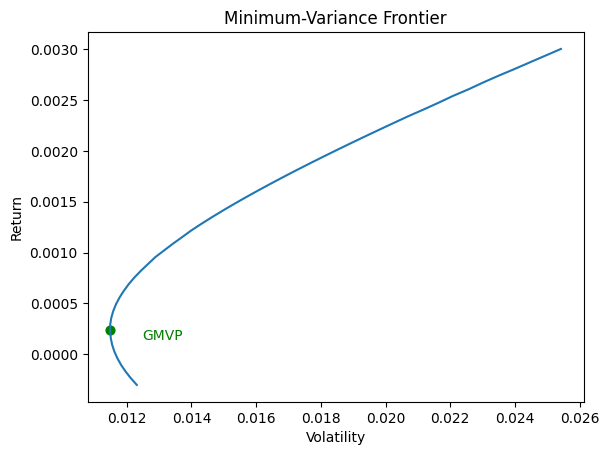

Assets allocation that yields to the lowest volatility: 
{'Weights': array([-0.0512707 ,  0.11953901, -0.06624052, -0.10753084,  0.02025252,
        0.04819128,  0.05297445,  0.15316389, -0.02607532,  0.07249727,
        0.30920355, -0.07679808,  0.04941284, -0.04723347,  0.02729083,
        0.15761019,  0.31075941,  0.02653365,  0.02772003]), 'Return': 0.00023801481707377435, 'Volatility': 0.01148623878981223}
Assets allocation that yields to the highest return: 
{'Weights': array([ 22.72389627, -37.67146373,  -5.89132516,  -3.49926483,
       -25.66492393, -81.58208535,   4.25052391,  40.78066141,
       -57.17395013,  26.17084089,  -2.70370081,  12.14561418,
         5.46560313,  67.95372228,  41.57676808, -24.08087194,
        -0.10563805,  31.87942554, -13.57383176]), 'Return': 0.3616112870904737, 'Volatility': 3.000000213212535}
Assets allocation that yields to the highest sharpe ratio: 
{'Weights': array([ 0.75230343, -1.03015967, -0.38049088, -0.9962421 , -1.22915112,
       -2

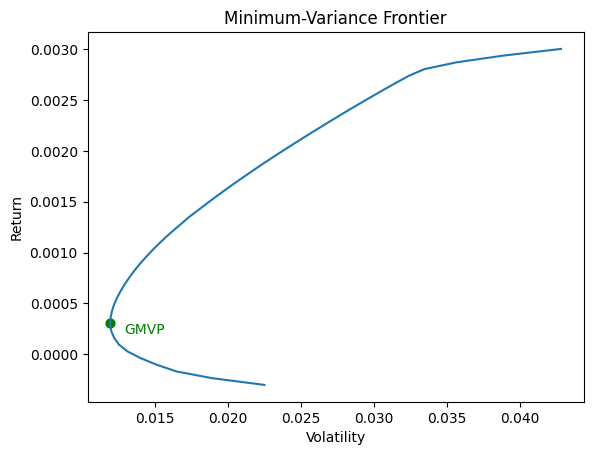

In [7]:
index = Index('^GSPC', "2020-01-01", "2023-12-31")
print(index)

ff = Fama_French("2020-01-01", "2023-12-31")
print(ff)

portfolio = Portfolio(["AAPL", "AMZN", "MSFT", "TSLA", "GOOGL", "NFLX", "JPM", "V", "PG", "DIS", "NVDA", "PFE", "INTC", "CSCO", "KO", "BAC", "ORCL", "IBM", "BA"],
                        "2020-01-01", "2023-12-31")
print(portfolio)

mvo = MVO(portfolio, ff, None) # No boundary specified
mvo.plot_MVO()

mvo.minimum_volatility()
print("Assets allocation that yields to the lowest volatility: ")
print(mvo.strategies['minimum_volatility'])

mvo.maximum_return(3)
print("Assets allocation that yields to the highest return: ")
print(mvo.strategies['maximum_return'])

mvo.maximum_sharpe()
print("Assets allocation that yields to the highest sharpe ratio: ")
print(mvo.strategies['maximum_sharpe'])

mvo.maximum_utility(2)
print("Assets allocation that yields to the highest utility score: ")
print(mvo.strategies['maximum_utility'])

mvo_long = MVO(portfolio, ff, [[0,1]] * len(portfolio.tickers)) # Boundary is set to be 0 to 1
mvo_long.plot_MVO()

## Application

In [8]:
nasdaq100 = open('nasdaq100.txt', 'r').read().split('\n')
dj30 = open('dj30.txt', 'r').read().split('\n')
train_tickers = nasdaq100
train_tickers.remove('GEHC')
train_tickers.remove('CEG')
train_tickers.remove('GFS')
train_tickers.remove('SPLK')

In [9]:
train_start, train_end = ["2003-04-01", "2023-4-30"]
ff_train = Fama_French(train_start, train_end)
print(ff_train)
portfolio_train = Portfolio(train_tickers, train_start, train_end)
print(portfolio_train)

Benchmark Reference: Fama-French
 	 Risk-free rate: 4.777250247279921e-05
 	 Volatility: 0
[*********************100%%**********************]  97 of 97 completed
Portfolio Basic Information:
 	 Portfolio Assets: ['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'AZN', 'BIIB', 'BKNG', 'BKR', 'CCEP', 'CDNS', 'CDW', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DLTR', 'DXCM', 'EA', 'EXC', 'FANG', 'FAST', 'FTNT', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KHC', 'KLAC', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDB', 'MDLZ', 'MELI', 'META', 'MNST', 'MRNA', 'MRVL', 'MSFT', 'MU', 'NFLX', 'NVDA', 'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'TEAM', 'TMUS', 'TSLA', 'TTD', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']
 	 Average Returns: [0.0015448719543127

In [10]:
test_start, test_end = ["2023-05-01", "2024-05-01"]
index_test = Index('^SPX', test_start, test_end)
print(index_test)
portfolio_test = Portfolio(train_tickers, test_start, test_end)
print(portfolio_test)

[*********************100%%**********************]  1 of 1 completed
Benchmark Reference: ^SPX
 	 Mean rate of return: 0.0007809603938256362
 	 Volatility: 0.007365569759322577
[*********************100%%**********************]  97 of 97 completed
Portfolio Basic Information:
 	 Portfolio Assets: ['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'AZN', 'BIIB', 'BKNG', 'BKR', 'CCEP', 'CDNS', 'CDW', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DLTR', 'DXCM', 'EA', 'EXC', 'FANG', 'FAST', 'FTNT', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KHC', 'KLAC', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDB', 'MDLZ', 'MELI', 'META', 'MNST', 'MRNA', 'MRVL', 'MSFT', 'MU', 'NFLX', 'NVDA', 'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'TEAM', 'TMUS', 'TSLA', 'TTD', 'TTWO', 'TXN', 'VRS

Assets allocation that yields to the highest sharpe ratio: 
{'Weights': array([2.15219605e-02, 1.12844443e-01, 0.00000000e+00, 1.83325035e-16,
       9.84048997e-17, 4.48724174e-17, 0.00000000e+00, 8.66142011e-17,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.87905789e-17, 0.00000000e+00, 1.07552856e-16, 0.00000000e+00,
       7.22795475e-03, 1.17283570e-16, 0.00000000e+00, 4.83147593e-17,
       3.86075315e-02, 0.00000000e+00, 0.00000000e+00, 1.39591030e-17,
       2.78707721e-17, 7.03723511e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.01054419e-16,
       4.26230702e-02, 0.00000000e+00, 1.00356464e-17, 1.35220340e-16,
       0.00000000e+00, 6.41794335e-02, 0.00000000e+00, 5.38441904e-17,
       5.91228997e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.37117694e-16,
       1.24005623e-17, 6.46831895e-02, 7.27093082e-18, 9.18590291e-17,
     

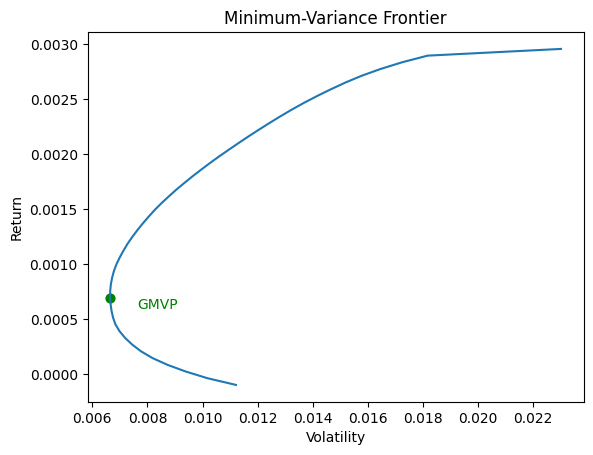

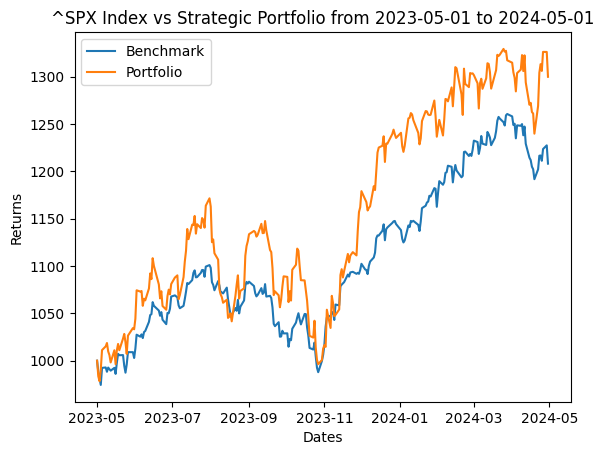

Strategic portfolio outperformed the index ^SPX by 9.18% throughout the holding period


In [11]:
mvo_train = MVO(portfolio_train, ff_train, [[0,1]] * len(train_tickers))
mvo_train.maximum_sharpe()
print("Assets allocation that yields to the highest sharpe ratio: ")
print(mvo_train.strategies['maximum_sharpe'])

mvo_train.plot_MVO()
plotReturns(portfolio_test, index_test, mvo_train.strategies['maximum_sharpe']['Weights'])